Le but de ce travail est d'étudier l'écoulement de Stockes, c'est à dire un écoulement dominé par les forces de viscosité, dans une cavité carée dont la surface supérieure se déplace. Pour cela nous partons de l'équation de Navier-Stokes.

$\frac{\partial u}{\partial t}+u\cdot \nabla u = -\frac{1}{\rho} \nabla p+ \nu \nabla^2 u$


Ce qui sous forme non-dimentionnelle s'écrit:

$ Re (\frac{\partial u}{\partial t} + u \cdot \nabla u) = -\nabla p + \nabla^2 u $

Où Re est le coefficient de Reynolds, u la vitesse non-dimentional et p la pression non-dimensional. Chercher à résoudre l'écoulement de Stokes revient à prendre un nombre de Reynolds proche de zéro. Nous prenons alors le terme de gauche égal à zéro et prenons le rotationnel de la partie de droite afin d'obtenir: 

$\nabla^2\omega=0$

où $\omega$ est la vorticité et vaut $\omega = \nabla \times u$

On défini égallement la fonction de courrant $\psi$ à partir des relations suiantes:

$u=\frac{\partial\psi}{\partial y}$ et $v=\frac{\partial \psi}{\partial x}$

ce qui nous donne:

$\nabla^2 \psi = - \omega$

Maintenant que nous avons l'équation de Laplace pour $\omega$ et l'équation de Poisson pour $\psi$ nous pouvons commencer à écrire notre code.

Pour commencer nous importons les librairies nécessaires

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16


Nous définissons la taille de la cavité, et la taille des pas qui seront utilisés pour la discrétisation de notre problème, ainsi que la précision que nous voulons pour notre état relaxé. 

In [2]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6


Nous avons une fonction qui nous permettera de faire nos calculs jusqu'à avoir atteind la précison désirée. 

In [3]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm


Notre équation de Laplace se discrétise de la manière suivante:

$\frac{\omega_{i+1,j}-2\omega_{i,j}+\omega_{i-1,j}}{dx^2}+\frac{\omega_{i,j+1}-2\omega_{i,j}+\omega_{i,j-1}}{dy^2} =0$

En isolant la partie qui nous intéresse on obtient: 

$\omega_{i,j}=\frac{dy^2(\omega_{i+1,j}+\omega_{i-1,j})+dx^2(\omega_{i,j+1}+\omega_{i,j-1})}{2dx^2+2dy^2}$

Maintenant discrétisons l'équation de Poisson:

$\frac{\psi_{i+1,j}-2\psi_{i,j}+\psi_{i-1,j}}{dx^2}+\frac{\psi_{i,j+1}-2\psi_{i,j}+\psi_{i,j-1}}{dy^2} =-\omega_{i,j}$

En isolant la partie qui nous intéresse on obtient:

$\psi_{i,j}=\frac{dy^2(\psi_{i+1,j}+\psi_{i-1,j})+dx^2(\psi_{i,j+1}+\psi_{i,j-1})+\omega_{i,j}dx^2dy^2}{2dx^2+2dy^2}$

Pour les conditions aux bords nous avons les équations suivantes: 

$\omega_{i,ny-1}=-\frac{1}{2 dy^2}(8 \psi_{i,ny-2}-\psi_{i,ny-3})-\frac{1}{dy}$ pour le bord supérieur

$\omega_{0,j}=-\frac{1}{2 dy^2}(8 \psi_{1,j}-\psi_{2,j})$ pour le coté droit

$\omega_{nx-1,j}=-\frac{1}{2 dy^2}(8 \psi_{nx-2,j}-\psi_{nx-3,j})$ pour le coté gauche

$\omega_{i,0}=-\frac{1}{2 dy^2}(8 \psi_{i,1}-\psi_{i,2})$ pour le bord inférieur

Nous appliquons alors notre équation de Laplace, notre équation de Poisson et nos conditions aux bord sur notre cavitée jusqu'à obtenir un état suffisament relaxé, ce qui se traduit par le code suivant:

In [4]:
omega=numpy.zeros((ny,nx))
psy=numpy.zeros((ny,nx))
omegac=omega.copy()
psyc=psy.copy()

normO,normP=10,10
while normO>l1_target or normP>l1_target:
    
    #print(omega)
    omegac[1:-1,1:-1]=(dy**2*(omega[1:-1,2:]+omega[1:-1,0:-2])+dx**2*(omega[2:,1:-1]+omega[0:-2,1:-1]))/(2*dx**2+2*dy**2)
    
    omegac[ny-1,:]=-(1/(2*dy**2))*(8*psy[ny-2,:]-psy[ny-3,:])-3/dy #bord sup
    omegac[0,:]=-(1/(2*dy**2))*(8*psy[1,:]-psy[2,:]) #bord inf
    omegac[:,0]=-(1/(2*dx**2))*(8*psy[:,1]-psy[:,2])
    omegac[:,nx-1]=-(1/(2*dx**2))*(8*psy[:,nx-2]-psy[:,nx-3])
    
    psyc[1:-1,1:-1]=(dy**2*(psy[1:-1,2:]+psy[1:-1,0:-2])+dx**2*(psy[2:,1:-1]\
                                        +psy[0:-2,1:-1])+omegac[1:-1,1:-1]*dx**2*dy**2)/(2*(dx**2+dy**2))
    #print(omega)
    normO=L1norm(omegac,omega)
    normP=L1norm(psyc,psy)
    
    omega=omegac.copy()
    psy=psyc.copy()

Une fois relaxé, le système ressemble à ce qui suit:

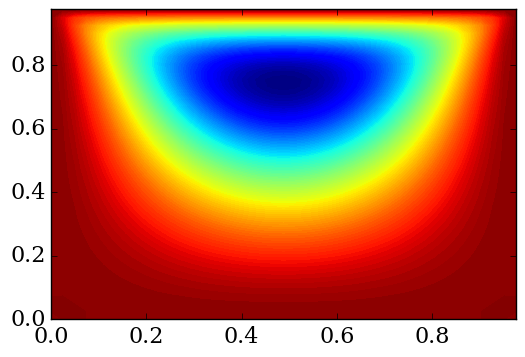

In [5]:
x=numpy.arange(0,1,1/nx)
y=numpy.arange(0,1,1/ny)
pyplot.contourf(x,y,psy,100)

Le graphe semble correspondre à ce que nous voulions, pour vérifier nos résultats nous faisons les petits tests proposés.

In [6]:
omegaplus=numpy.abs(omega)
psyplus=numpy.abs(psy)

In [7]:
print (numpy.max(omegaplus))
print (numpy.max(psyplus))

78.1926612286
0.0998451724383


In [8]:
numpy.round(psy[32,::8], 4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

Une fois de plus nous obtenons les résultats attendus. 

Nous pouvons voir par le test numérique ainsi que par le graphe, que la cuve fini par se relaxer dans un état symétrique. On peut en conclure que l'écoulement de Stokes préserve la symétrie initiale du problème. On voit sur le graphe grâce aux couleurs, que la fonction de courant reste nulle sur les bord et que se forment des zones équipotentielles concentriques. Le déplacement du fluide doit effectivement être nul le long d'une paroi. On voir que là où la cuve est le plus affectée, c'est en haut, là où la plaque bougeait. 